# Simple event plotting of CNN mPMT dataset with segmentation

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
print(os.getcwd())
sys.path.append('/home/nprouse/WatChMaL/WatChMaL_analysis/')
sys.path.append('/home/nprouse/WatChMaL/WatChMaL_analysis/WatChMaL')

/home/nprouse/WatChMaL/WatChMaL_analysis/event_plotting


In [4]:
from watchmal.dataset.cnn_mpmt.cnn_mpmt_segmentation_dataset import CNNmPMTSegmentationDataset
from watchmal.dataset.h5_dataset import H5Dataset, H5TrueDataset
from watchmal.dataset.DigiTruthMapping import DigiTruthMapping

In [5]:
from omegaconf import OmegaConf

In [6]:
# Create mapping if not already created

# digi_dataset = H5Dataset(h5_path='/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_digihits.h5',
#                          is_distributed=False)
# true_dataset = H5TrueDataset(h5_path='/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truehits.h5')
# mapping = DigiTruthMapping(digi_dataset, true_dataset)

In [7]:
def channel_to_position(channel):
    channel = channel % 19 
    theta = (channel<12)*2*np.pi*channel/12 + ((channel >= 12) & (channel<18))*2*np.pi*(channel-12)/6
    radius = 0.2*(channel<18)+0.2*(channel<12)
    position = [radius*np.cos(theta), radius*np.sin(theta)] # note this is [y, x] or [row, column]
    return position

In [8]:
def plot_event(data, mpmt_pos, old_convention=False, **plot_args):
    fig = plt.figure(figsize=(20,12))
    ax = fig.add_subplot(111)
    mpmts = ax.scatter(mpmt_pos[:, 1], mpmt_pos[:, 0], s=380, facecolors='none', edgecolors='0.9')
    indices = np.indices(data.shape)
    channels = indices[0].flatten()
    positions = indices[1:].reshape(2,-1).astype(np.float64)
    positions += channel_to_position(channels)
    if old_convention:
        positions[1] = max(mpmt_pos[:, 1])-positions[1]
    pmts = ax.scatter(positions[1], positions[0], c=data.flatten(), s=3, **plot_args)
    plt.colorbar(pmts)

## Testing with pi0 data

### Loading data and plotting test event

In [9]:
digi_dataset_conf = OmegaConf.create({
    "_target_" : "watchmal.dataset.cnn_mpmt.cnn_mpmt_dataset.CNNmPMTDataset",
    "h5file" : "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_digihits.h5",
    "mpmt_positions_file" : "/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz",
    "collapse_arrays" : False,
    "is_distributed" : False})

In [30]:
dataset = CNNmPMTSegmentationDataset(
    digi_dataset_config=digi_dataset_conf,
    true_hits_h5file='/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truehits.h5',
    digi_truth_mapping_file='truth_for_data.pkl',
    parent_type="max")

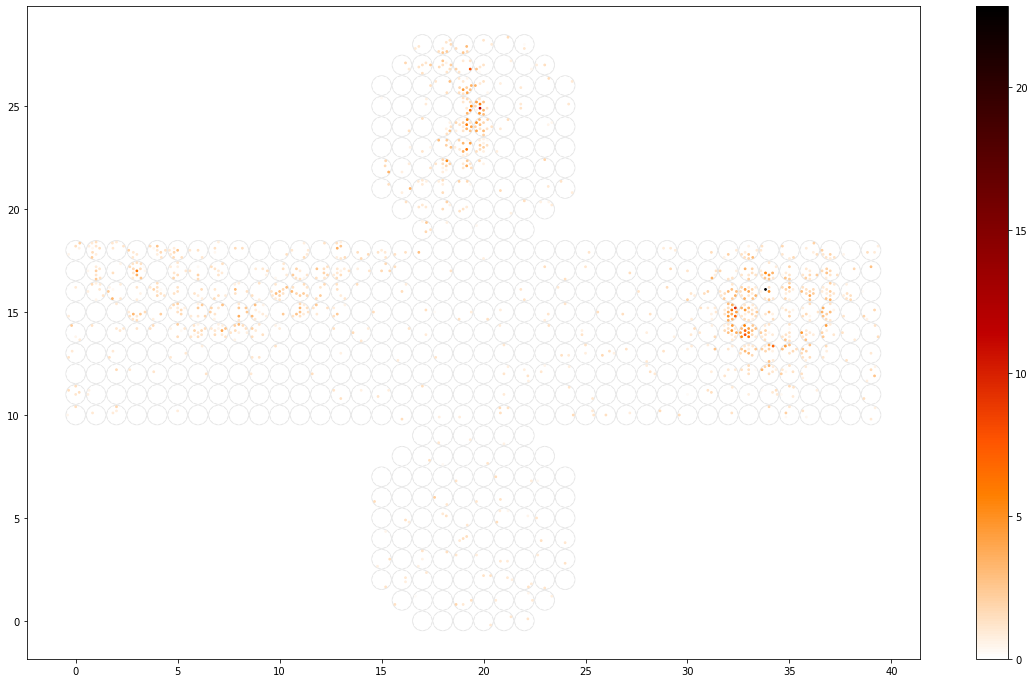

In [11]:
event = dataset.__getitem__(2)
data = event['data']
plot_event(data, dataset.digi_dataset.mpmt_positions, cmap=plt.cm.gist_heat_r)

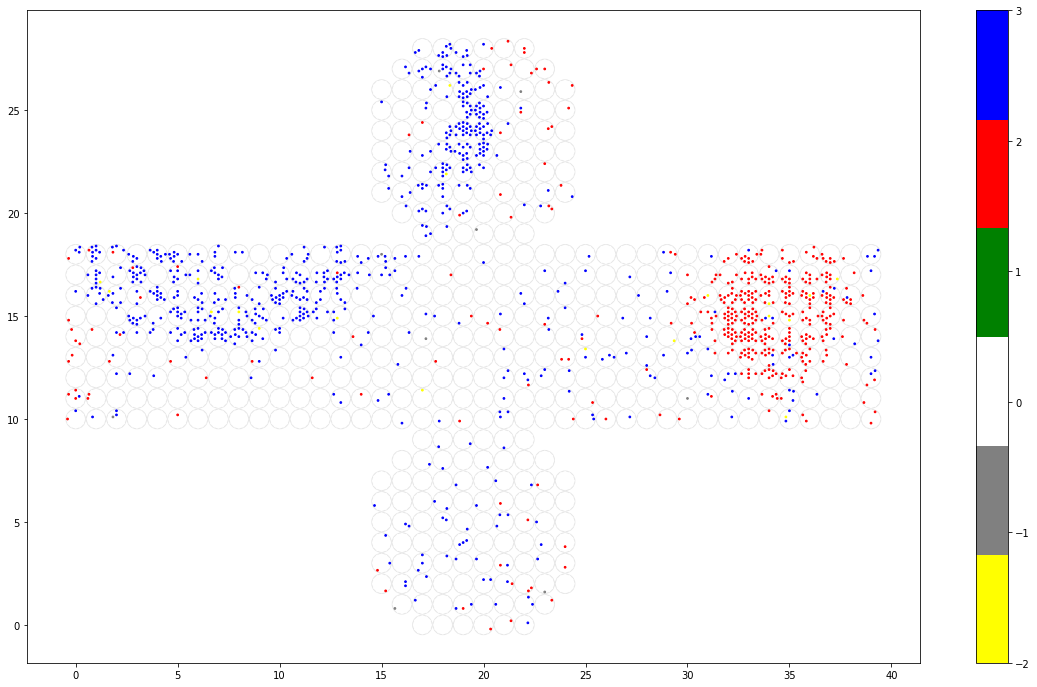

In [12]:
segmentation = event['segmentation']
plot_event(segmentation, dataset.digi_dataset.mpmt_positions,
           cmap=ListedColormap(["yellow", "gray", "white", "green", "red", "blue"]))

## Profile speed for loading 1000 events

In [31]:
%%time
for i in range(1000):
    dataset.__getitem__(i)

CPU times: user 961 ms, sys: 12.4 ms, total: 973 ms
Wall time: 973 ms
